In [53]:
import time
import numpy as np
import pandas as pd

In [54]:
import tensorflow.python.keras as keras
from tensorflow.python.keras.layers import Layer
import tensorflow as tf
import dan_models
import dan_utils

In [55]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [56]:
class_set = [2, 3, 4]
v, v_class, id_402, part1, part2, seg, det_list_class, near_road_set  \
        = dan_utils.load_data(class_set, res=11, randseed=25)

There are 5 class(es)


C:\Users\10169\anaconda3\envs\dan_traff\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [57]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_color_set = ['b', 'g', 'y', 'black', 'r']
class_i = 4

near_road = np.array(near_road_set[class_i])
flow = v_class[class_i].iloc[:, 2:-1]

prop = 0.3  # proportion of training data
from_day = 22
to_day = 31
num_links = v_class[class_i].shape[0]

image_train, image_test, day_train, day_test, label_train, label_test\
= dan_utils.sliding_window(
    flow, near_road, from_day, to_day, prop, num_links
)

t_input = image_train.shape[2]
t_pre = label_train.shape[2]
k = image_train.shape[1]

(1008, 5, 12, 40)
(302, 5, 12, 40)
(706, 5, 12, 40)
(302, 40, 6)
(706, 40, 6)


In [58]:
input_data = keras.Input(shape=(k,t_input,num_links), name='input_data')
input_HA = keras.Input(shape=(num_links, t_pre), name='input_HA')

finish_model = dan_models.build_model(input_data, input_HA)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 5, 12, 40)]  0                                            
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 5, 12, 40)    160         input_data[0][0]                 
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 5, 12, 40)    14440       batch_normalization_9[0][0]      
__________________________________________________________________________________________________
average_pooling2d_6 (AveragePoo (None, 5, 12, 40)    0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [59]:
finish_model.compile(optimizer='adam', loss='mean_squared_error')

In [60]:
X_train = image_train
X_HA_train = day_train
label_train = label_train

In [61]:
#模型拟合与评估
finish_model.fit([X_train,X_HA_train], label_train, epochs=1000, batch_size=2048,
validation_data=([image_test,day_test], label_test))
# finish_model.evaluate(image_test, label_test)

Epoch 1/1000
1/1 [==============================] - 1s 734ms/step - loss: 230495.0156 - val_loss: 223015.3906
Epoch 2/1000
1/1 [==============================] - 0s 57ms/step - loss: 230037.4844 - val_loss: 222537.1562
Epoch 3/1000
1/1 [==============================] - 0s 55ms/step - loss: 229576.6094 - val_loss: 222038.1875
Epoch 4/1000
1/1 [==============================] - 0s 56ms/step - loss: 229110.3281 - val_loss: 221505.7031
Epoch 5/1000
1/1 [==============================] - 0s 62ms/step - loss: 228637.2500 - val_loss: 220929.8125
Epoch 6/1000
1/1 [==============================] - 0s 51ms/step - loss: 228155.1719 - val_loss: 220296.1875
Epoch 7/1000
1/1 [==============================] - 0s 57ms/step - loss: 227662.3906 - val_loss: 219595.8594
Epoch 8/1000
1/1 [==============================] - 0s 49ms/step - loss: 227156.6562 - val_loss: 218830.4531
Epoch 9/1000
1/1 [==============================] - 0s 57ms/step - loss: 226636.4219 - val_loss: 218002.9219
Epoch 10/1000
1/1 

1/1 [==============================] - 0s 45ms/step - loss: 109006.5156 - val_loss: 138112.7031
Epoch 76/1000
1/1 [==============================] - 0s 50ms/step - loss: 108327.5156 - val_loss: 140714.3438
Epoch 77/1000
1/1 [==============================] - 0s 62ms/step - loss: 107857.7344 - val_loss: 135503.7344
Epoch 78/1000
1/1 [==============================] - 0s 63ms/step - loss: 107391.8828 - val_loss: 136506.8594
Epoch 79/1000
1/1 [==============================] - 0s 53ms/step - loss: 106706.1094 - val_loss: 132890.1406
Epoch 80/1000
1/1 [==============================] - 0s 63ms/step - loss: 106224.9922 - val_loss: 130177.7031
Epoch 81/1000
1/1 [==============================] - 0s 64ms/step - loss: 105783.5859 - val_loss: 131880.6094
Epoch 82/1000
1/1 [==============================] - 0s 55ms/step - loss: 105351.6719 - val_loss: 127566.2891
Epoch 83/1000
1/1 [==============================] - 0s 59ms/step - loss: 104821.7969 - val_loss: 127353.7422
Epoch 84/1000
1/1 [=====

Epoch 150/1000
1/1 [==============================] - 0s 52ms/step - loss: 89882.2812 - val_loss: 98549.7891
Epoch 151/1000
1/1 [==============================] - 0s 55ms/step - loss: 89640.9141 - val_loss: 97553.0391
Epoch 152/1000
1/1 [==============================] - 0s 49ms/step - loss: 89477.6406 - val_loss: 97311.0625
Epoch 153/1000
1/1 [==============================] - 0s 63ms/step - loss: 89327.5000 - val_loss: 97600.9375
Epoch 154/1000
1/1 [==============================] - 0s 59ms/step - loss: 89132.7969 - val_loss: 97884.0078
Epoch 155/1000
1/1 [==============================] - 0s 52ms/step - loss: 88961.8828 - val_loss: 98025.7812
Epoch 156/1000
1/1 [==============================] - 0s 61ms/step - loss: 88785.0312 - val_loss: 98821.4062
Epoch 157/1000
1/1 [==============================] - 0s 53ms/step - loss: 88617.6406 - val_loss: 98075.4297
Epoch 158/1000
1/1 [==============================] - 0s 62ms/step - loss: 88456.5000 - val_loss: 97068.8984
Epoch 159/1000
1/1 

1/1 [==============================] - 0s 55ms/step - loss: 76150.8203 - val_loss: 86240.8594
Epoch 226/1000
1/1 [==============================] - 0s 51ms/step - loss: 75971.7188 - val_loss: 85820.4453
Epoch 227/1000
1/1 [==============================] - 0s 56ms/step - loss: 75871.1172 - val_loss: 85815.4219
Epoch 228/1000
1/1 [==============================] - 0s 52ms/step - loss: 75695.6641 - val_loss: 85635.0547
Epoch 229/1000
1/1 [==============================] - 0s 52ms/step - loss: 75496.9766 - val_loss: 85106.4766
Epoch 230/1000
1/1 [==============================] - 0s 65ms/step - loss: 75396.9688 - val_loss: 84883.3438
Epoch 231/1000
1/1 [==============================] - 0s 60ms/step - loss: 75210.2656 - val_loss: 85015.3594
Epoch 232/1000
1/1 [==============================] - 0s 55ms/step - loss: 75020.6484 - val_loss: 85514.8203
Epoch 233/1000
1/1 [==============================] - 0s 49ms/step - loss: 74889.4375 - val_loss: 85627.0859
Epoch 234/1000
1/1 [==============

1/1 [==============================] - 0s 50ms/step - loss: 64759.1133 - val_loss: 72516.5000
Epoch 301/1000
1/1 [==============================] - 0s 64ms/step - loss: 64618.1406 - val_loss: 72025.0547
Epoch 302/1000
1/1 [==============================] - 0s 52ms/step - loss: 64474.2109 - val_loss: 71602.5391
Epoch 303/1000
1/1 [==============================] - 0s 59ms/step - loss: 64333.4648 - val_loss: 71401.4922
Epoch 304/1000
1/1 [==============================] - 0s 62ms/step - loss: 64196.9453 - val_loss: 71306.6250
Epoch 305/1000
1/1 [==============================] - 0s 55ms/step - loss: 64039.2852 - val_loss: 71088.8594
Epoch 306/1000
1/1 [==============================] - 0s 59ms/step - loss: 63890.1602 - val_loss: 70913.0078
Epoch 307/1000
1/1 [==============================] - 0s 58ms/step - loss: 63773.4102 - val_loss: 70614.5234
Epoch 308/1000
1/1 [==============================] - 0s 65ms/step - loss: 63597.5508 - val_loss: 70451.9766
Epoch 309/1000
1/1 [==============

1/1 [==============================] - 0s 62ms/step - loss: 53898.0469 - val_loss: 61029.5000
Epoch 376/1000
1/1 [==============================] - 0s 55ms/step - loss: 53724.4414 - val_loss: 61634.4258
Epoch 377/1000
1/1 [==============================] - 0s 54ms/step - loss: 53651.2812 - val_loss: 61374.9023
Epoch 378/1000
1/1 [==============================] - 0s 62ms/step - loss: 53458.7070 - val_loss: 60791.0156
Epoch 379/1000
1/1 [==============================] - 0s 55ms/step - loss: 53306.8984 - val_loss: 60221.8516
Epoch 380/1000
1/1 [==============================] - 0s 64ms/step - loss: 53198.3789 - val_loss: 60082.6562
Epoch 381/1000
1/1 [==============================] - 0s 55ms/step - loss: 53086.9922 - val_loss: 60347.8086
Epoch 382/1000
1/1 [==============================] - 0s 57ms/step - loss: 52929.6797 - val_loss: 60188.3555
Epoch 383/1000
1/1 [==============================] - 0s 58ms/step - loss: 52791.0039 - val_loss: 59966.5508
Epoch 384/1000
1/1 [==============

1/1 [==============================] - 0s 76ms/step - loss: 45799.8633 - val_loss: 55815.7695
Epoch 451/1000
1/1 [==============================] - 0s 98ms/step - loss: 45664.7852 - val_loss: 55410.5938
Epoch 452/1000
1/1 [==============================] - 0s 63ms/step - loss: 45614.1250 - val_loss: 55664.9922
Epoch 453/1000
1/1 [==============================] - 0s 51ms/step - loss: 45470.3242 - val_loss: 55513.4453
Epoch 454/1000
1/1 [==============================] - 0s 45ms/step - loss: 45362.0469 - val_loss: 55160.3047
Epoch 455/1000
1/1 [==============================] - 0s 46ms/step - loss: 45263.3281 - val_loss: 54994.4805
Epoch 456/1000
1/1 [==============================] - 0s 53ms/step - loss: 45171.0234 - val_loss: 55290.7891
Epoch 457/1000
1/1 [==============================] - 0s 53ms/step - loss: 45068.8359 - val_loss: 55870.7461
Epoch 458/1000
1/1 [==============================] - 0s 52ms/step - loss: 44962.5547 - val_loss: 55964.0664
Epoch 459/1000
1/1 [==============

1/1 [==============================] - 0s 49ms/step - loss: 38671.4766 - val_loss: 52806.3281
Epoch 526/1000
1/1 [==============================] - 0s 61ms/step - loss: 38604.7852 - val_loss: 52544.6875
Epoch 527/1000
1/1 [==============================] - 0s 52ms/step - loss: 38486.3750 - val_loss: 52638.5703
Epoch 528/1000
1/1 [==============================] - 0s 47ms/step - loss: 38393.8633 - val_loss: 52948.5000
Epoch 529/1000
1/1 [==============================] - 0s 66ms/step - loss: 38326.7539 - val_loss: 52931.2695
Epoch 530/1000
1/1 [==============================] - 0s 57ms/step - loss: 38240.5312 - val_loss: 52165.5195
Epoch 531/1000
1/1 [==============================] - 0s 59ms/step - loss: 38149.0820 - val_loss: 52030.1719
Epoch 532/1000
1/1 [==============================] - 0s 51ms/step - loss: 38086.9492 - val_loss: 53383.9766
Epoch 533/1000
1/1 [==============================] - 0s 55ms/step - loss: 38042.1133 - val_loss: 53785.0273
Epoch 534/1000
1/1 [==============

1/1 [==============================] - 0s 45ms/step - loss: 33052.8672 - val_loss: 45733.2812
Epoch 601/1000
1/1 [==============================] - 0s 46ms/step - loss: 32945.0234 - val_loss: 46432.1523
Epoch 602/1000
1/1 [==============================] - 0s 48ms/step - loss: 32866.3359 - val_loss: 48067.3984
Epoch 603/1000
1/1 [==============================] - 0s 45ms/step - loss: 32869.7227 - val_loss: 47043.3984
Epoch 604/1000
1/1 [==============================] - 0s 44ms/step - loss: 32712.5566 - val_loss: 46512.5195
Epoch 605/1000
1/1 [==============================] - 0s 52ms/step - loss: 32712.4082 - val_loss: 46963.7969
Epoch 606/1000
1/1 [==============================] - 0s 52ms/step - loss: 32574.8965 - val_loss: 46975.1602
Epoch 607/1000
1/1 [==============================] - 0s 43ms/step - loss: 32575.7012 - val_loss: 45337.9297
Epoch 608/1000
1/1 [==============================] - 0s 51ms/step - loss: 32500.3809 - val_loss: 45138.9414
Epoch 609/1000
1/1 [==============

1/1 [==============================] - 0s 54ms/step - loss: 27972.6152 - val_loss: 41644.6289
Epoch 676/1000
1/1 [==============================] - 0s 52ms/step - loss: 27862.2520 - val_loss: 41848.3086
Epoch 677/1000
1/1 [==============================] - 0s 49ms/step - loss: 27842.0605 - val_loss: 42636.7891
Epoch 678/1000
1/1 [==============================] - 0s 72ms/step - loss: 27742.9023 - val_loss: 42917.0547
Epoch 679/1000
1/1 [==============================] - 0s 67ms/step - loss: 27702.6230 - val_loss: 43162.9180
Epoch 680/1000
1/1 [==============================] - 0s 52ms/step - loss: 27634.1836 - val_loss: 43883.6211
Epoch 681/1000
1/1 [==============================] - 0s 53ms/step - loss: 27560.1289 - val_loss: 43555.8477
Epoch 682/1000
1/1 [==============================] - 0s 51ms/step - loss: 27520.5508 - val_loss: 42155.5781
Epoch 683/1000
1/1 [==============================] - 0s 51ms/step - loss: 27447.3809 - val_loss: 41936.1797
Epoch 684/1000
1/1 [==============

1/1 [==============================] - 0s 71ms/step - loss: 23729.6270 - val_loss: 41346.6016
Epoch 751/1000
1/1 [==============================] - 0s 68ms/step - loss: 23654.9219 - val_loss: 42392.1094
Epoch 752/1000
1/1 [==============================] - 0s 73ms/step - loss: 23600.9316 - val_loss: 42073.3281
Epoch 753/1000
1/1 [==============================] - 0s 66ms/step - loss: 23553.6797 - val_loss: 41142.8711
Epoch 754/1000
1/1 [==============================] - 0s 69ms/step - loss: 23488.9531 - val_loss: 40705.9219
Epoch 755/1000
1/1 [==============================] - 0s 65ms/step - loss: 23417.5234 - val_loss: 39697.9766
Epoch 756/1000
1/1 [==============================] - 0s 67ms/step - loss: 23299.5918 - val_loss: 39599.9375
Epoch 757/1000
1/1 [==============================] - 0s 69ms/step - loss: 23282.6328 - val_loss: 40931.4453
Epoch 758/1000
1/1 [==============================] - 0s 62ms/step - loss: 23161.0723 - val_loss: 40453.5859
Epoch 759/1000
1/1 [==============

1/1 [==============================] - 0s 68ms/step - loss: 19909.2500 - val_loss: 36569.3398
Epoch 826/1000
1/1 [==============================] - 0s 65ms/step - loss: 19911.8066 - val_loss: 36784.5469
Epoch 827/1000
1/1 [==============================] - 0s 73ms/step - loss: 19843.3320 - val_loss: 35602.3242
Epoch 828/1000
1/1 [==============================] - 0s 71ms/step - loss: 19805.6309 - val_loss: 34519.7383
Epoch 829/1000
1/1 [==============================] - 0s 74ms/step - loss: 19767.9980 - val_loss: 34289.8555
Epoch 830/1000
1/1 [==============================] - 0s 80ms/step - loss: 19760.9609 - val_loss: 34311.6055
Epoch 831/1000
1/1 [==============================] - 0s 70ms/step - loss: 19658.9023 - val_loss: 34970.7188
Epoch 832/1000
1/1 [==============================] - 0s 75ms/step - loss: 19654.2812 - val_loss: 35145.3047
Epoch 833/1000
1/1 [==============================] - 0s 86ms/step - loss: 19609.2227 - val_loss: 34149.8750
Epoch 834/1000
1/1 [==============

1/1 [==============================] - 0s 78ms/step - loss: 17153.4180 - val_loss: 29914.0020
Epoch 901/1000
1/1 [==============================] - 0s 70ms/step - loss: 17129.8594 - val_loss: 30262.5176
Epoch 902/1000
1/1 [==============================] - 0s 76ms/step - loss: 17129.6426 - val_loss: 31200.3594
Epoch 903/1000
1/1 [==============================] - 0s 71ms/step - loss: 17060.6426 - val_loss: 31485.7910
Epoch 904/1000
1/1 [==============================] - 0s 67ms/step - loss: 17059.6230 - val_loss: 31157.8477
Epoch 905/1000
1/1 [==============================] - 0s 77ms/step - loss: 16984.0000 - val_loss: 30514.2969
Epoch 906/1000
1/1 [==============================] - 0s 71ms/step - loss: 16957.0469 - val_loss: 30199.7363
Epoch 907/1000
1/1 [==============================] - 0s 74ms/step - loss: 16921.4141 - val_loss: 30064.9141
Epoch 908/1000
1/1 [==============================] - 0s 73ms/step - loss: 16896.7305 - val_loss: 29988.7148
Epoch 909/1000
1/1 [==============

1/1 [==============================] - 0s 76ms/step - loss: 14993.5645 - val_loss: 29191.4785
Epoch 976/1000
1/1 [==============================] - 0s 72ms/step - loss: 14993.5957 - val_loss: 29079.9043
Epoch 977/1000
1/1 [==============================] - 0s 76ms/step - loss: 14907.6455 - val_loss: 28835.6348
Epoch 978/1000
1/1 [==============================] - 0s 64ms/step - loss: 14919.1436 - val_loss: 28642.5176
Epoch 979/1000
1/1 [==============================] - 0s 73ms/step - loss: 14891.7188 - val_loss: 28789.1680
Epoch 980/1000
1/1 [==============================] - 0s 75ms/step - loss: 14830.3184 - val_loss: 29160.0684
Epoch 981/1000
1/1 [==============================] - 0s 74ms/step - loss: 14796.0566 - val_loss: 29470.3086
Epoch 982/1000
1/1 [==============================] - 0s 74ms/step - loss: 14767.1074 - val_loss: 29395.1719
Epoch 983/1000
1/1 [==============================] - 0s 65ms/step - loss: 14760.8213 - val_loss: 28778.0859
Epoch 984/1000
1/1 [==============

In [62]:
#模型预测
model_pre = finish_model.predict([image_test,day_test])

In [63]:
#计算各项误差指标

m = 5
nrmse_mean = dan_utils.nrmse_loss_func(model_pre, label_test, m)
mape_mean = dan_utils.mape_loss_func(model_pre, label_test, m)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test, m)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test, m)

print('nrmse = ' + str(nrmse_mean) + '\n' + 'mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

nrmse = 0.11191105108649615
mape = 0.36184636843451345
smape = 0.36439828151167536
mae = 116.45847340794812


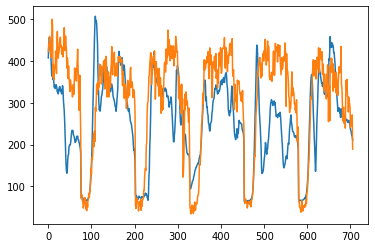

In [64]:
import matplotlib.pyplot as plt

plt.plot(model_pre[:, 0, 0])
plt.plot(label_test[:, 0, 0])

In [65]:
#模型保存
finish_model.save_weights('../model/base_ST-DTNN_%s_mape=%.5f_nrmse=%.5f.h5'%(class_color_set[class_i], mape_mean, nrmse_mean))
# finish_model.save_weights('../model/source_%s.h5'%(class_color_set[class_i]))